In [1]:
import os
import midas_touch2 as mt2
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import warnings
pd.options.display.max_columns = 100000
warnings.filterwarnings('ignore')

if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MT5 successfully initialised.\n")

MT5 successfully initialised.



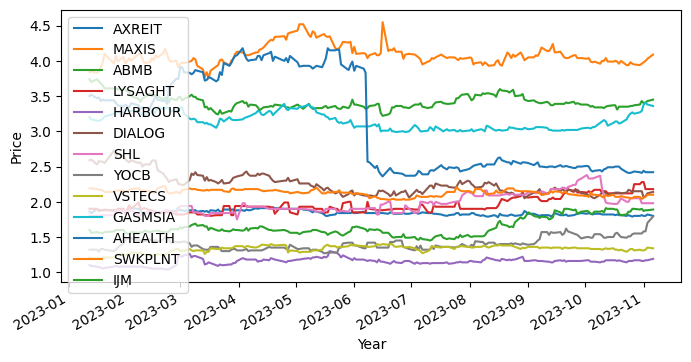

In [2]:
symbols = ['AXREIT', 'MAXIS', 'ABMB', 'LYSAGHT', 'HARBOUR', 
           'DIALOG', 'SHL', 'YOCB', 'VSTECS', 'GASMSIA', 
           'AHEALTH', 'SWKPLNT', 'IJM']

price_df = mt2.download_stocks(symbols)
# def extract_number(col_name):
#     return int(''.join(filter(str.isdigit, col_name)))
# rename_sym = ['5106.KL', '6012.KL', '2488.KL', '9199.KL', '2062.KL', '7277.KL', '6017.KL', '5159.KL', '5162.KL', '5209.KL', '7090.KL', '5135.KL', '3336.KL']
# price_df.columns = rename_sym
# #Sort DataFrame columns using the custom key
# sorted_columns = sorted(price_df.columns, key=extract_number)
# price_df = price_df[sorted_columns]

price_df.plot(figsize=(8,4))
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [3]:
def run_portfolio(prices, commission_rate=0.001):
    # Calculate Alpha1
    alpha1 = -(prices - prices.shift(5)) / prices.shift(5)
    alpha1 = alpha1.dropna() 
    weights = alpha1.div(alpha1.abs().sum(axis=1), axis=0)
    weights[weights < 0] = 0
    weights = weights.div(weights.sum(axis=1), axis=0)
    weights = weights.fillna(0)
    latest_weights = weights.iloc[-1]
    portfolio_returns = (weights.shift() * prices.pct_change()).sum(axis=1)
    portfolio_returns = portfolio_returns - commission_rate
    return weights, latest_weights

tickers = ['AXREIT','MAXIS','ABMB','LYSAGHT','HARBOUR',
           'DIALOG','SHL','YOCB','VSTECS','GASMSIA',
           'AHEALTH','SWKPLNT','IJM']
weights_df, latest_weights = run_portfolio(price_df)
latest_weights

AXREIT    -0.000000
MAXIS      0.000000
ABMB       0.000000
LYSAGHT    0.445025
HARBOUR    0.000000
DIALOG     0.066532
SHL        0.488443
YOCB       0.000000
VSTECS     0.000000
GASMSIA    0.000000
AHEALTH   -0.000000
SWKPLNT    0.000000
IJM       -0.000000
Name: 2023-11-06 00:00:00, dtype: float64

In [4]:
#change allocation units to test

In [19]:
previous_allocation_df = mt2.get_folder(folder_name='daily_allocation')
previous_portfolio_df = mt2.get_folder(folder_name='daily_portfolio')
if previous_allocation_df is not None and previous_portfolio_df is not None:
    # Process the existing CSV data
    total_investment = abs(previous_portfolio_df['Total Value'].iloc[-1])
    allocation_df = mt2.calculate_stock_allocation(total_investment, latest_weights, price_df)
    allocation_df['Holding Units'] = previous_allocation_df['Allocated Units']

else: #first run
    total_investment = 10000 #TRY 15K 10K 5K
    allocation_df = mt2.calculate_stock_allocation(total_investment, latest_weights, price_df)
    # Handle the initial run scenario
    print("This is the initial run. No previous allocation data available.")
    allocation_df['Holding Units'] = 0

# Calculate Entry and Exit Units
allocation_df['Entry Units'] = allocation_df.apply(
    lambda row: max(row['Allocated Units'] - row['Holding Units'], 0), axis=1
)
allocation_df['Exit Units'] = allocation_df.apply(
    lambda row: max(row['Holding Units'] - row['Allocated Units'], 0), axis=1
)
numeric_cols = allocation_df.select_dtypes(include=['number']).astype(float)

for col in numeric_cols.columns:
    allocation_df[col] = numeric_cols[col]
#SEND ORDER FIRST
print(allocation_df)
mt2.execute_trades_from_data(allocation_df)


# + confirm order



# Calculate the portfolio value
if previous_allocation_df is not None and previous_portfolio_df is not None: #2nd run onwards
    starting_cash = previous_portfolio_df['Cash Value'].iloc[-1]
    current_share_value = (allocation_df['Allocated Units']*allocation_df['Share Price']).sum()

else: #first run
    starting_cash = 10000
    current_share_value = (allocation_df['Entry Units']*allocation_df['Share Price']).sum()

portfolio_df = mt2.compile_portfolio_data(allocation_df, starting_cash, current_share_value)

mt2.save_df_to_csv(portfolio_df, 
                   folder_name='daily_portfolio', 
                   file_name='balance',
                   append=True)
mt2.save_df_to_csv(allocation_df, 
                   folder_name='daily_allocation', 
                   file_name='allocation')


   Share Symbol  Share Price  Allocated Units   Weights  Holding Units  \
0        AXREIT         1.80              0.0 -0.000000            0.0   
1         MAXIS         4.09              0.0  0.000000            0.0   
2          ABMB         3.45              0.0  0.000000            0.0   
3       LYSAGHT         2.18           2000.0  0.445025         2000.0   
4       HARBOUR         1.19              0.0  0.000000            0.0   
5        DIALOG         2.14            300.0  0.066532          300.0   
6           SHL         1.98           2400.0  0.488443         2400.0   
7          YOCB         1.79              0.0  0.000000            0.0   
8        VSTECS         1.34              0.0  0.000000            0.0   
9       GASMSIA         3.36              0.0  0.000000            0.0   
10      AHEALTH         2.42              0.0 -0.000000            0.0   
11      SWKPLNT         2.10              0.0  0.000000            0.0   
12          IJM         1.89          

In [21]:
portfolio_df


,Starting Capital,Purchase Cost,Sale Proceed,Cash Value,Portfolio Value,Total Value
0,246.0,0.0,0.0,246.0,9754.0,10000.0


In [7]:
allocation_df

,Share Symbol,Share Price,Allocated Units,Weights,Holding Units,Entry Units,Exit Units
0,AXREIT,1.80,0.0,-0.000000,0.0,0.0,0.0
1,MAXIS,4.09,0.0,0.000000,0.0,0.0,0.0
2,ABMB,3.45,0.0,0.000000,0.0,0.0,0.0
3,LYSAGHT,2.18,2000.0,0.445025,0.0,2000.0,0.0
4,HARBOUR,1.19,0.0,0.000000,0.0,0.0,0.0
5,DIALOG,2.14,300.0,0.066532,0.0,300.0,0.0
6,SHL,1.98,2400.0,0.488443,0.0,2400.0,0.0
7,YOCB,1.79,0.0,0.000000,0.0,0.0,0.0
8,VSTECS,1.34,0.0,0.000000,0.0,0.0,0.0
9,GASMSIA,3.36,0.0,0.000000,0.0,0.0,0.0


In [8]:
total_investment

10000

In [9]:
latest_weights

AXREIT    -0.000000
MAXIS      0.000000
ABMB       0.000000
LYSAGHT    0.445025
HARBOUR    0.000000
DIALOG     0.066532
SHL        0.488443
YOCB       0.000000
VSTECS     0.000000
GASMSIA    0.000000
AHEALTH   -0.000000
SWKPLNT    0.000000
IJM       -0.000000
Name: 2023-11-06 00:00:00, dtype: float64

In [10]:
price_df

,AXREIT,MAXIS,ABMB,LYSAGHT,HARBOUR,DIALOG,SHL,YOCB,VSTECS,GASMSIA,AHEALTH,SWKPLNT,IJM
time,,,,,,,,,,,,,
2023-01-12,1.86,3.84,3.74,1.90,1.10,2.59,1.80,1.32,1.21,3.20,3.50,2.19,1.60
2023-01-13,1.84,3.85,3.70,1.90,1.09,2.60,1.80,1.32,1.20,3.17,3.52,2.19,1.56
2023-01-16,1.90,3.83,3.74,1.90,1.08,2.53,1.80,1.32,1.19,3.15,3.47,2.18,1.57
2023-01-17,1.87,3.85,3.71,1.88,1.07,2.58,1.80,1.29,1.20,3.15,3.48,2.17,1.56
2023-01-18,1.88,3.91,3.68,1.88,1.07,2.57,1.81,1.33,1.19,3.16,3.43,2.17,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,1.81,3.96,3.43,2.28,1.16,2.15,1.98,1.55,1.31,3.29,2.41,2.04,1.90
2023-11-01,1.80,3.98,3.40,2.28,1.16,2.06,1.98,1.58,1.31,3.38,2.44,2.06,1.87
2023-11-02,1.80,4.00,3.41,2.18,1.17,2.08,1.98,1.58,1.32,3.41,2.42,2.07,1.88


In [11]:
symbol = "AHEALTH"
if not mt5.symbol_select(symbol, True):
    print(f"Symbol {symbol} not found, cannot proceed.")
    mt5.shutdown()
    quit()

# Retrieve the symbol properties
symbol_info = mt5.symbol_info(symbol)
if symbol_info is None:
    print(f"Failed to get data on {symbol}, cannot proceed.")
    mt5.shutdown()
    quit()

lot_size = 100
price = mt5.symbol_info_tick(symbol).ask 

# Define the limit order (assuming a buy limit order here)
request = {
    "action": mt5.TRADE_ACTION_PENDING,
    "symbol": symbol,
    "volume": 100.0,
    "type": mt5.ORDER_TYPE_BUY_LIMIT,
    "price": price,
    "sl": 0.0, 
    "tp": 0.0,  
    "magic": 234000,  # Magic number to identify your order
    "comment": "Python script open",
    "type_time": mt5.ORDER_TIME_GTC,  # Good till canceled
    "type_filling": mt5.ORDER_FILLING_RETURN,
}

result = mt5.order_send(request)

# Check the result
if result is None:
    print("The order_send function returned None. This could indicate an issue with the request or the connection.")
    print("Last error:", mt5.last_error())
else:
    if result.retcode != mt5.TRADE_RETCODE_DONE:
        print("Order failed, retcode =", result.retcode)
    else:
        print("Order successfully placed")

# Check the result
if result.retcode != mt5.TRADE_RETCODE_DONE:
    print("Order failed, retcode =", result.retcode)
else:
    print("Order successfully placed")

Order successfully placed
Order successfully placed


In [12]:
allocation_df

,Share Symbol,Share Price,Allocated Units,Weights,Holding Units,Entry Units,Exit Units
0,AXREIT,1.80,0.0,-0.000000,0.0,0.0,0.0
1,MAXIS,4.09,0.0,0.000000,0.0,0.0,0.0
2,ABMB,3.45,0.0,0.000000,0.0,0.0,0.0
3,LYSAGHT,2.18,2000.0,0.445025,0.0,2000.0,0.0
4,HARBOUR,1.19,0.0,0.000000,0.0,0.0,0.0
5,DIALOG,2.14,300.0,0.066532,0.0,300.0,0.0
6,SHL,1.98,2400.0,0.488443,0.0,2400.0,0.0
7,YOCB,1.79,0.0,0.000000,0.0,0.0,0.0
8,VSTECS,1.34,0.0,0.000000,0.0,0.0,0.0
9,GASMSIA,3.36,0.0,0.000000,0.0,0.0,0.0


In [13]:
previous_allocation_df

In [14]:
portfolio_df

,Starting Capital,Purchase Cost,Sale Proceed,Cash Value,Portfolio Value,Total Value
0,10000,9754.0,0.0,246.0,9754.0,10000.0


In [15]:
############DUMMY DATA##############
# new_allocation_df = allocation_df.copy()
# new_allocation_df['Allocated Units']=700
# new_allocation_df
# #save_df to csv
# mt2.save_df_to_csv(new_allocation_df, 
#                    folder_name='daily_allocation', 
#                    file_name='allocation')
# new_allocation_df

In [16]:
starting_cash = 10000
prev_portfolio_value = 0
purchase_cost = (allocation_df['Share Price']*allocation_df['Entry Units']).sum()

cash_balance = starting_cash - purchase_cost
portfolio_value = prev_portfolio_value + purchase_cost + cash_balance
print('Total Investment: ', starting_cash)
print('Purchase Cost: ', purchase_cost)
print('Cash Balance: ', cash_balance)
print('Portfolio Value: ', portfolio_value)

# Define the data dictionary
portfolio_data = {
    'Total Investment': [starting_cash],
    'Purchase Cost': [purchase_cost],
    'Cash Balance': [cash_balance],
    'Portfolio Value': [portfolio_value]
}

# Create the DataFrame
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df



Total Investment:  10000
Purchase Cost:  9754.0
Cash Balance:  246.0
Portfolio Value:  10000.0


,Total Investment,Purchase Cost,Cash Balance,Portfolio Value
0,10000,9754.0,246.0,10000.0


In [17]:
#if daily_allocation not found:
starting_cash = 10000
prev_portfolio_value = 0
purchase_cost = (allocation_df['Share Price']*allocation_df['Entry Units']).sum()
cash_balance = starting_cash - purchase_cost
portfolio_value = prev_portfolio_value + purchase_cost + cash_balance
allocation_df = mt2.calculate_stock_allocation(total_investment, latest_weights, price_df)




# send order mt5 till 9.05am

# if still pending then cancel and resend market order

# confirmed market order executed then save allocation_df

# #initial save allocation_df
# mt2.save_df_to_csv(allocation_df, 
#                      folder_name='daily_allocation', 
#                      file_name='allocation')

# mt2.save_df_to_csv(portfolio_value, 
#                    folder_name='daily_portfolio_value', 
#                    file_name='net_value', 
#                    append=True)

# else:  found allocation_df



In [18]:



#allocation
mt2.save_df_to_csv(allocation_df, folder_name='daily_allocation', file_name='allocation')
#portfolio value
portfolio_value = allocation_df['Share Price'] * allocation_df['Entry Units']
mt2.save_df_to_csv(portfolio_value, folder_name='daily_portfolio_value',file_name='net_value')


Data saved in daily_allocation\allocation_2023-11-07.csv


KeyError: 'Entry Units'